<a href="https://colab.research.google.com/github/mch5153/Special-Exhibit-Impact-An-ML-Based-Lift-Analysis/blob/main/Special_Exhibit_Impact_An_ML_Based_Lift_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Correlation Analysis:                vst  mean_s_v
vst       1.000000  0.218267
mean_s_v  0.218267  1.000000


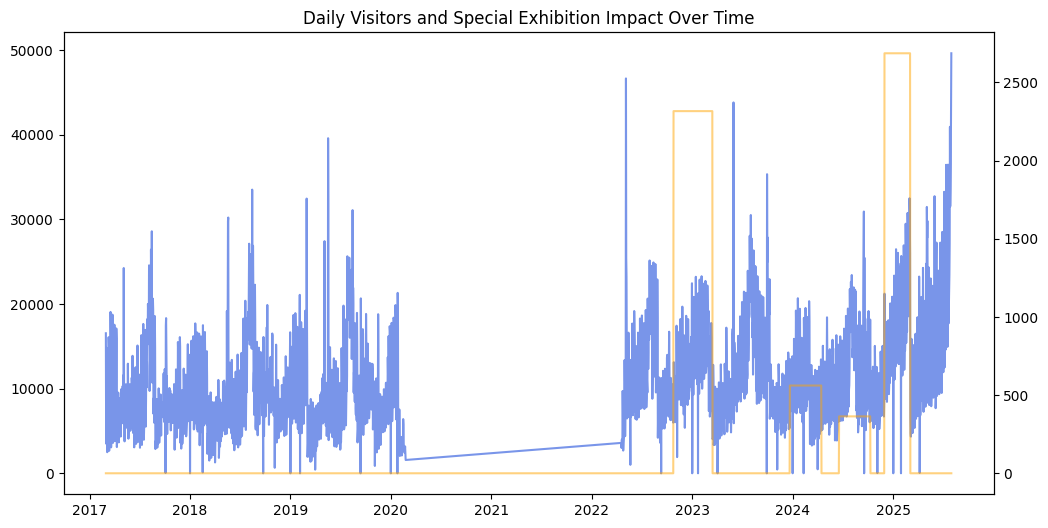

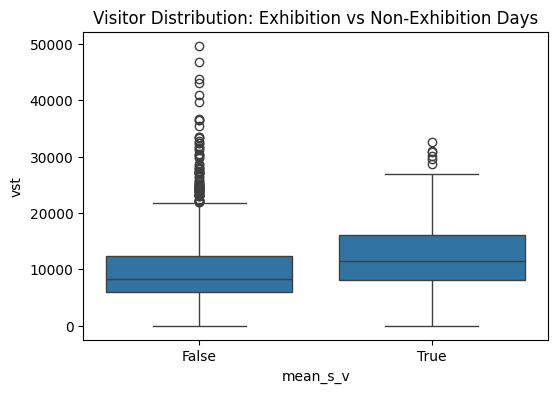

Feature Importance: month       0.239650
wknd        0.237886
day         0.225662
year        0.166870
wkd         0.059861
mean_s_v    0.054019
crn         0.016052
dtype: float64


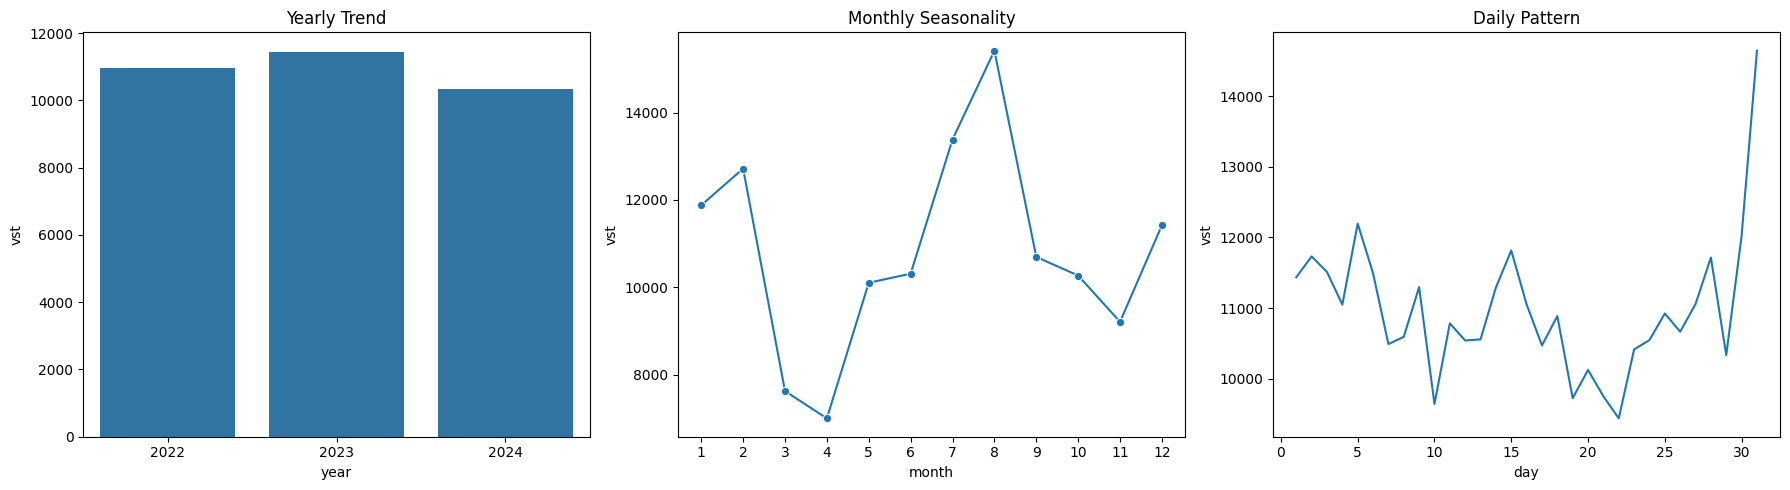


Exhibition Performance (Lift Analysis):
   Exhibition Name  Avg Daily Lift
1     Vienna 1900     6185.250851
0    Habsburg 600     3745.189789
2          Stupas      338.603478
3          Indian    -1056.828158


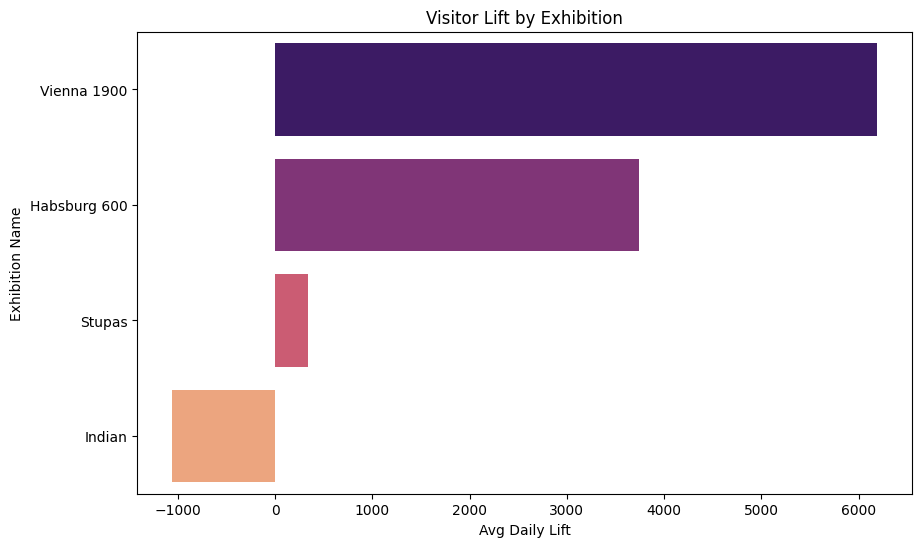

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# 1. Data Loading & Initial Processing
raw_data = pd.read_csv('museum_visitors.csv', encoding='cp949')

# Visitor Data Setup
df_m = raw_data.iloc[:, :7].set_axis(['year', 'month', 'day', 'wkd', 'wknd', 'vst', 'crn'], axis=1)
df_m['single_day'] = pd.to_datetime(df_m[['year', 'month', 'day']])

# Label Encoding for Categorical Variables
le = LabelEncoder()
for col in ['wkd', 'wknd', 'crn']:
    df_m[col] = le.fit_transform(df_m[col])

# Special Exhibition Data Setup
s_exhi = raw_data.iloc[:, 8:12].set_axis(['name', 's', 'f', 's_v'], axis=1).dropna(subset=['name']).copy()
s_exhi['s'], s_exhi['f'] = pd.to_datetime(s_exhi['s']), pd.to_datetime(s_exhi['f'])

# Calculate Daily Visitor Intensity per Special Exhibition
s_exhi['daily_v'] = s_exhi['s_v'] / ((s_exhi['f'] - s_exhi['s']).dt.days + 1)

def get_mean_s_v(d):
    return s_exhi.loc[(s_exhi['s'] <= d) & (s_exhi['f'] >= d), 'daily_v'].sum()

df_m['mean_s_v'] = df_m['single_day'].apply(get_mean_s_v)

# 2. Exploratory Data Analysis (EDA)
# Correlation Analysis
print("Correlation Analysis:", df_m[['vst', 'mean_s_v']].corr())

# Visitor vs Exhibition Impact Visualization
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df_m['single_day'], df_m['vst'], color='royalblue', label='Daily Visitors', alpha=0.7)
ax2 = ax1.twinx()
ax2.plot(df_m['single_day'], df_m['mean_s_v'], color='orange', label='Exhibition Impact Score', alpha=0.5)
plt.title('Daily Visitors and Special Exhibition Impact Over Time')
plt.show()

# Boxplots for Comparative Analysis
plt.figure(figsize=(6, 4))
sns.boxplot(x=(df_m['mean_s_v'] > 0), y='vst', data=df_m)
plt.title('Visitor Distribution: Exhibition vs Non-Exhibition Days')
plt.show()

# 3. Machine Learning: Feature Importance Analysis
features = ['year', 'month', 'day', 'wkd', 'wknd', 'crn', 'mean_s_v']
X = df_m[features]
y = df_m['vst']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Output Feature Importance
importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("Feature Importance:", importance)

# 4. Baseline Trend Analysis (Aggregated Patterns)
df_trend = df_m[df_m['year'].isin([2022, 2023, 2024])]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# [1] Year: Growth Trend
sns.barplot(data=df_trend, x='year', y='vst', ax=axes[0], errorbar=None)
axes[0].set_title('Yearly Trend')

# [2] Month: Seasonality
sns.lineplot(data=df_trend, x='month', y='vst', ax=axes[1], marker='o', errorbar=None)
axes[1].set_title('Monthly Seasonality')
axes[1].set_xticks(range(1, 13))

# [3] Day: Intra-month Pattern
sns.lineplot(data=df_trend, x='day', y='vst', ax=axes[2], errorbar=None)
axes[2].set_title('Daily Pattern')

plt.tight_layout()
plt.show()

# 5. Counterfactual Simulation: Lift Effect Analysis

# Generate Baseline (Special Exhibition Impact = 0)
df_virtual = df_m[features].copy()
df_virtual['mean_s_v'] = 0
df_m['expected_vst'] = rf.predict(df_virtual)

# Calculate Pure Lift Score (Actual - Baseline)
df_m['lift_score'] = df_m['vst'] - df_m['expected_vst']

# Aggregate Lift Effect by Exhibition
exhi_results = []
for _, row in s_exhi.iterrows():
    mask = (df_m['single_day'] >= row['s']) & (df_m['single_day'] <= row['f'])
    avg_lift = df_m.loc[mask, 'lift_score'].mean()
    exhi_results.append({'Exhibition Name': row['name'], 'Avg Daily Lift': avg_lift})

# Final Performance Ranking
final_ranking = pd.DataFrame(exhi_results).sort_values(by='Avg Daily Lift', ascending=False)
print("\nExhibition Performance (Lift Analysis):\n", final_ranking)

plt.figure(figsize=(10, 6))
sns.barplot(x='Avg Daily Lift', y='Exhibition Name', data=final_ranking, palette="magma", hue='Exhibition Name')
plt.title('Visitor Lift by Exhibition')
plt.show()